# 1. 이해하기

## 1.1 전체 흐름

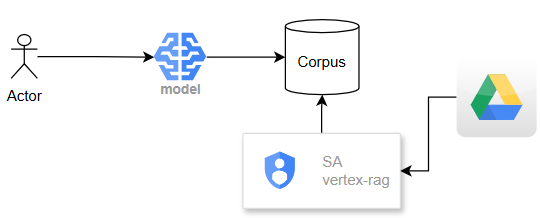

## 1.2 코드 흐름

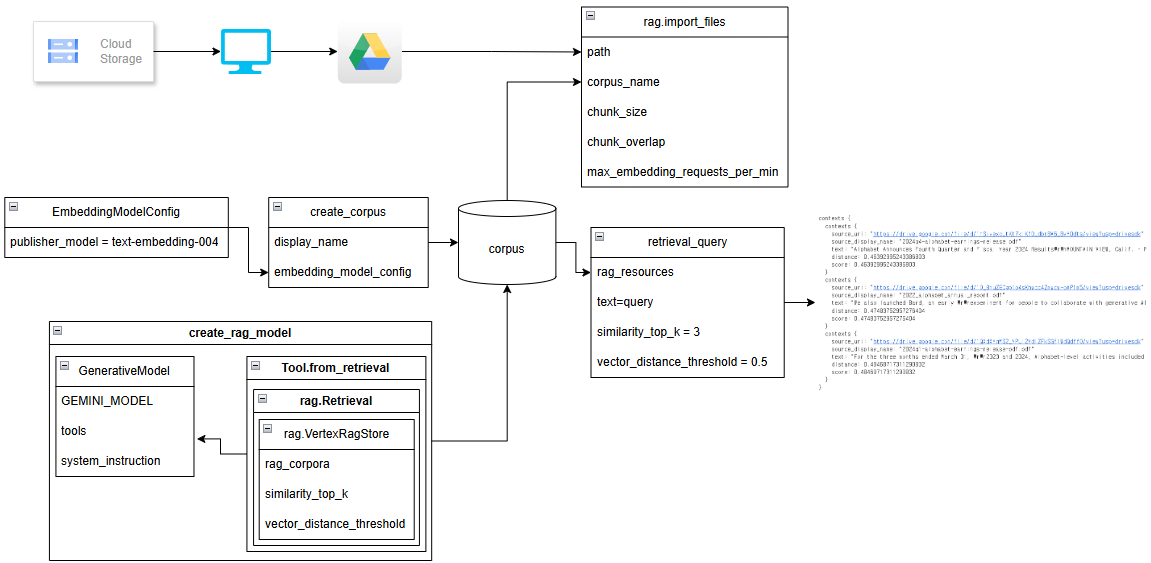

## 1.3 문서 이해

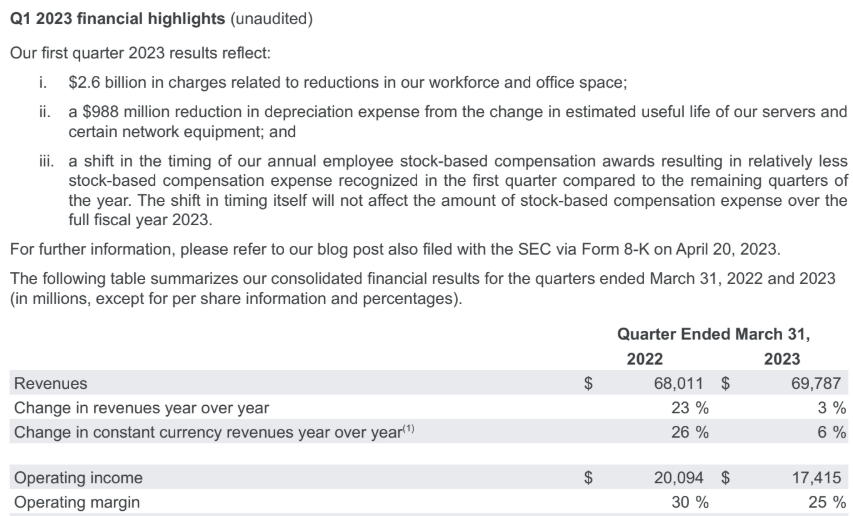

영어 문서에서 한글로 질문했을 경우 결과 확인

## 1.4 제약사항

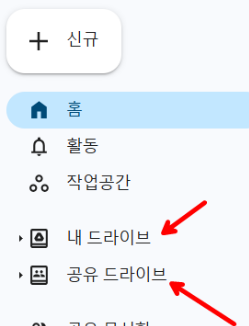

2024년 12월 기준 공유 드라이브는 지원되지 않음.

# 2. 환경설정

## 2.1 라이브러리 설치

In [ ]:
!pip install google-cloud-aiplatform

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## 2.2 환경변수 설정

In [ ]:
import os

PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))
LOCATION = str(os.environ.get("GOOGLE_CLOUD_REGION", "us-central1"))

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"LOCATION: {LOCATION}")

PROJECT_ID: younkicho-364103
LOCATION: us-central1


##2.3 Gemini 초기화

In [ ]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## 2.4 google drive에 file upload

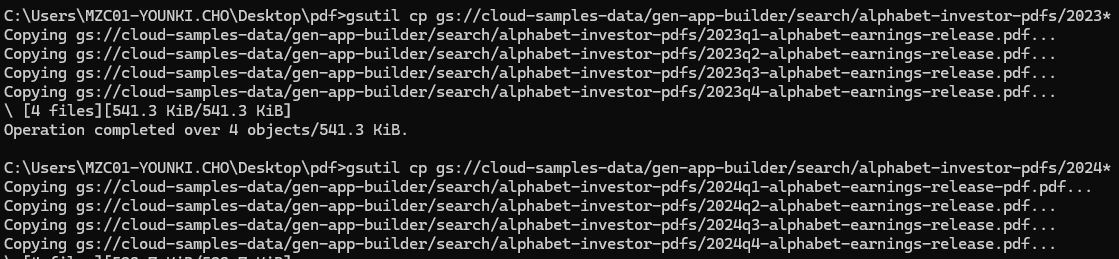

위와 같이 다음 명령를 이용하여 2021년부터 2024년까지의 pdf 파일을 다운 받는다.

gsutil cp gs://cloud-samples-data/gen-app-builder/search/alphabet-investor-pdfs/2021* ./

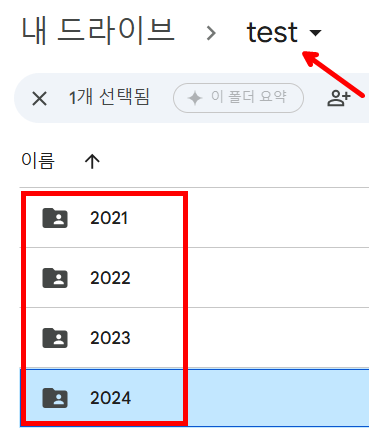

구글 드라이브에 임시 폴더를 만들고 위와 같이 년도 폴더를 만든 후 다운받은 pdf 파일을 저장한다.

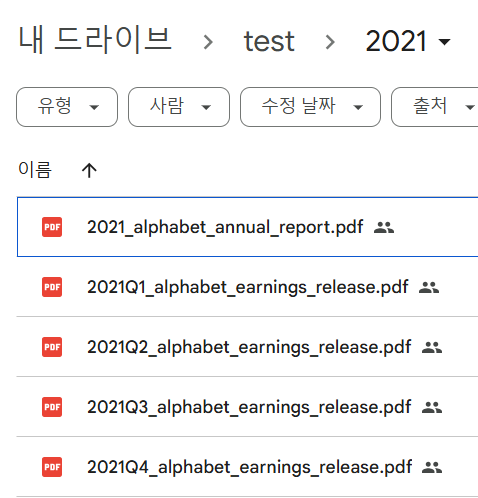

그러면 위와 같이 년도 폴더에 파일이 저장된 것을 확인할 수 있다.

## 2.5 구글 드라이브에 권한 부여

In [ ]:
PROJECT_NUMBER=!gcloud projects list\
 --filter="$(gcloud config get-value project)"\
  --format="value(PROJECT_NUMBER)"
PROJECT_NUMBER=PROJECT_NUMBER[0]

In [ ]:
tmp=f"service-{PROJECT_NUMBER}@gcp-sa-vertex-rag.iam.gserviceaccount.com"
tmp

'service-429718924597@gcp-sa-vertex-rag.iam.gserviceaccount.com'

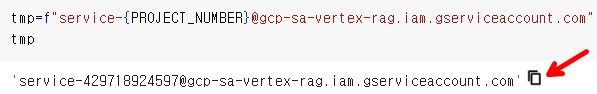

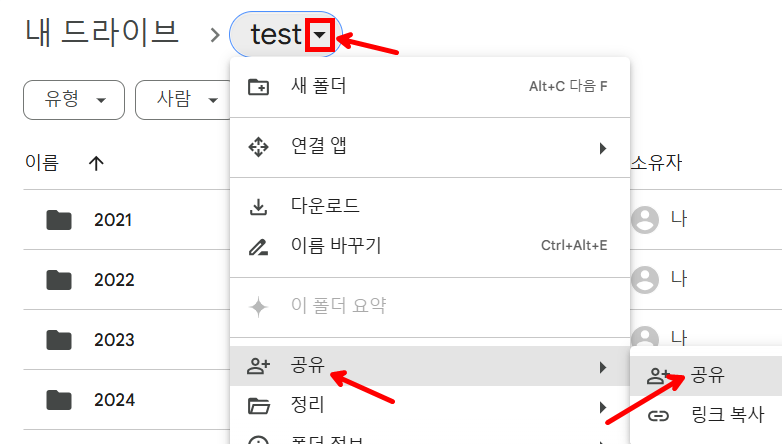

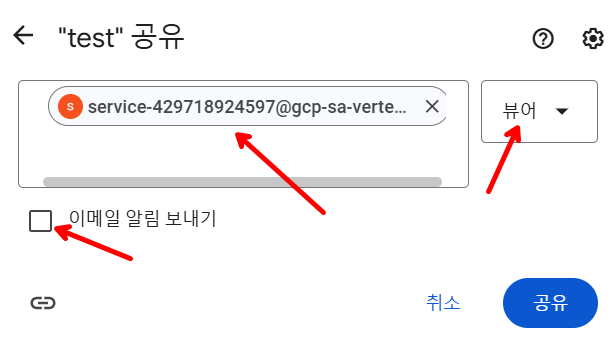

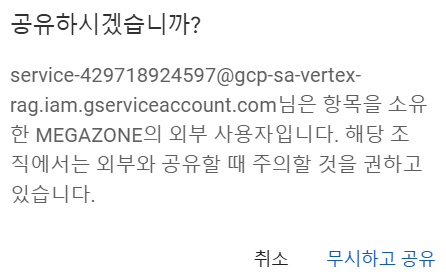

# 3. RAG 구현

## 3.1 RAG Corpus 생성

In [ ]:
from vertexai.preview import rag

EMBEDDING_MODEL = "publishers/google/models/text-embedding-004"
DISPLAY_NAME="gcs-rag-corpus"

In [ ]:
embedding_model_config = rag.EmbeddingModelConfig(publisher_model=EMBEDDING_MODEL)

rag_corpus = rag.create_corpus(
    display_name=DISPLAY_NAME,
    embedding_model_config=embedding_model_config,
)

In [ ]:
rag.list_corpora()

ListRagCorporaPager<rag_corpora {
  name: "projects/younkicho-364103/locations/us-central1/ragCorpora/4680365912744787968"
  display_name: "gcs-rag-corpus"
  rag_embedding_model_config {
    vertex_prediction_endpoint {
      endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
    }
  }
  rag_vector_db_config {
    rag_managed_db {
    }
    rag_embedding_model_config {
      vertex_prediction_endpoint {
        endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
      }
    }
  }
  create_time {
    seconds: 1739944152
    nanos: 531217000
  }
  update_time {
    seconds: 1739944152
    nanos: 531217000
  }
  corpus_status {
    state: ACTIVE
  }
  vector_db_config {
    rag_managed_db {
    }
    rag_embedding_model_config {
      vertex_prediction_endpoint {
        endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
      }
    

## 3.2 upload

### 3.2.1 import files from Google Drive

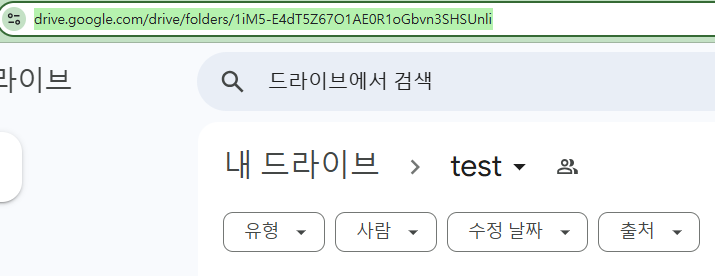

In [ ]:
INPUT_GDRIVE="https://drive.google.com/drive/folders/1iM5-E4dT5Z67O1AE0R1oGbvn3SHSUnli"

response = rag.import_files(
    corpus_name=rag_corpus.name,
    paths=[INPUT_GDRIVE],
    chunk_size=1024,
    chunk_overlap=100,
    max_embedding_requests_per_min=900
)
# result = await response.result()
print(f"Imported {response.imported_rag_files_count} files.")

Imported 0 files.


### 3.2.2 결과 확인

In [ ]:
query="""
2024년 구글의 총 수익은?
"""
response = rag.retrieval_query(
    rag_resources=[
        rag.RagResource(
            rag_corpus=rag_corpus.name,
        )
    ],
    text=query,
    similarity_top_k=5,  # Optional
    vector_distance_threshold=1,  # Optional
)
print(response)

contexts {
  contexts {
    source_uri: "https://drive.google.com/file/d/1nSivexcLtKt7kiKfD_dbr8V6_8vY0dts/view?usp=drivesdk"
    source_display_name: "2024q4-alphabet-earnings-release.pdf"
    text: "Alphabet Announces Fourth Quarter and Fiscal Year 2024 Results\r\nMOUNTAIN VIEW, Calif. – February 4, 2025 – Alphabet Inc. (NASDAQ: GOOG, GOOGL) today announced financial \r\nresults for the quarter and fiscal year ended December 31, 2024.\r\n• Consolidated Alphabet revenues in Q4 2024 increased 12% year over year to $96.5 billion reflecting robust \r\nmomentum across the business.\r\n• Google Services revenues increased 10% to $84.1 billion, reflecting the strong momentum across Google \r\nSearch & other and YouTube ads.\r\n• Google Cloud revenues increased 30% to $12.0 billion led by growth in Google Cloud Platform (GCP) across \r\ncore GCP products, AI Infrastructure, and Generative AI Solutions.\r\n• Total operating income increased 31% and operating margin expanded by 5% percentage p

# 4. 모델

## 4.1 모델 만들기

In [ ]:
from vertexai.preview.generative_models import (
    GenerativeModel,
    Tool
)
source = rag.VertexRagStore(
    rag_corpora=[rag_corpus.name],
    similarity_top_k=10,
    vector_distance_threshold=0.5
)

retrieval = rag.Retrieval(source=source)
rag_retrieval_tool = Tool.from_retrieval(retrieval)

In [ ]:
rag_gemini_model = GenerativeModel(
    "gemini-2.0-flash",
    tools=[rag_retrieval_tool],
    system_instruction="""
    내용 추론시 참고한 문서 이름과 내용도 반드시 출력한다.

    출력결과
      내용

    참고 문서
      - doc1

    참고 내용
      - doc1의 x페이지 y줄 인용
    """
)

In [ ]:
from IPython.display import display, Markdown
query="""
전년도 구글의 총 수익은?
"""

response = rag_gemini_model.generate_content(query)

display(Markdown(response.text))

2024년 구글의 총 수익은 3,500억 1,800만 달러입니다.

참고 문서
  - 2024q4-alphabet-earnings-release.pdf
      
참고 내용
  - 2024q4-alphabet-earnings-release.pdf의 2페이지 인용

In [ ]:
from IPython.display import Markdown, display

query="""
전전년도 구글의 총 수익은?
"""

response = rag_gemini_model.generate_content(query)

display(Markdown(response.text))

제공된 문서에서는 2023년 구글의 총 수익에 대한 정보를 찾을 수 없습니다. 대신, 2022년의 변화와 불확실성, AI 기술의 발전, 새로운 제품 출시 등에 대한 내용이 담겨 있습니다.

참고 문서
  - 2022_alphabet_annual_report.pdf
  - 2021_alphabet_annual_report.pdf

참고 내용
  - 2022_alphabet_annual_report.pdf의 전체 페이지
  - 2021_alphabet_annual_report.pdf의 전체 페이지


In [ ]:
from IPython.display import Markdown, display

query="""
2023년도 구글의 총 수익은?
"""

response = rag_gemini_model.generate_content(query)

display(Markdown(response.text))

제공된 문서에서는 2023년 구글의 총 수익에 대한 정보를 찾을 수 없습니다. 2022년 구글의 활동과 AI 기술 개발, 새로운 제품 출시 등에 대한 내용이 주를 이루고 있습니다.

참고 문서
  - 2022_alphabet_annual_report.pdf
  - 2021_alphabet_annual_report.pdf

참고 내용
  - 2022_alphabet_annual_report.pdf에는 2022년의 변화와 불확실성, AI 기술의 발전, 새로운 제품 출시 등에 대한 내용이 있습니다.
  - 2021_alphabet_annual_report.pdf에는 새로운 혁신, Pixel 6 및 Pixel 6 Pro 출시, 검색 기능 개선 등에 대한 내용이 있습니다.


In [ ]:
query="""
google's total revenue in 2023
"""

response = rag_gemini_model.generate_content(query)

display(Markdown(response.text))

Alphabet's total revenue for the year 2023 was $307.394 billion.

참고 문서
  - 2023q4-alphabet-earnings-release.pdf

참고 내용
  - Alphabet Announces Fourth Quarter and Fiscal Year 2023 Results. Revenues $ 282,836 $ 307,394


In [ ]:
from IPython.display import Markdown, display

query="""
compare google's revenue from 2024 to 2023
한글로 결과를 출력해줘
"""

response = rag_gemini_model.generate_content(query)

display(Markdown(response.text))

2024년 구글의 총 매출은 3,500억 1,800만 달러로, 2023년의 3,073억 9,400만 달러에 비해 14% 증가했습니다.

참고 문서
  - 2024q4-alphabet-earnings-release.pdf

참고 내용
  - 2024q4-alphabet-earnings-release.pdf: Revenues $ 307,394 $ 350,018 Change in revenues year over year 9 % 14 %

## 4.2 RAG 삭제

In [ ]:
corpus_list=rag.list_corpora()

for corpus in corpus_list:
  rag.delete_corpus(name=corpus.name)

Successfully deleted the RagCorpus.
Successfully deleted the RagCorpus.


# 5. reference

* https://rudaks.tistory.com/entry/langchain-%ED%85%8D%EC%8A%A4%ED%8A%B8-%EB%B6%84%ED%95%A0-Text-Splitter#google_vignette
* https://mechiru.github.io/google-api-proto/google_api_proto/google/cloud/aiplatform/v1beta1/struct.ImportRagFilesConfig.html

* https://velog.io/@minbrok/Vertex-AI-RAG-Engine%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%9C-Google-Drive-%ED%8C%8C%EC%9D%BC-RAG-%EA%B5%AC%ED%98%84
* https://cloud.google.com/vertex-ai/generative-ai/docs/samples/generativeaionvertexai-rag-import-files-async?hl=ko